<a href="https://colab.research.google.com/github/Starboy177/DataScience/blob/main/JasoHasiU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You need to submit a .ipynb file with the first four letters of one first name, the first four letters of one last name, and U6proj.

Ex.

A student named Avy Aguacate Avocado Palta will submit a file named "Avy_AvocU6proj.ipynb", since she normally just goes by Avy, and, when pressed, reports Avocado as her last name. The " _ " after "Avy" serves as the fourth "letter" in her first name.

Ex2.

Army Armadillo will submit a file named "ArmyArmaU6proj.ipynb"

# Unit 6 Project: Making a Generalized Linear Model (multiple predictors)

**Task**:

Two parts:

1. Propose a data set that's compatible with a generilized linear model structure built with pymc and/or bambi. Your data must have more than three potential predictor variables. I must approve your submission before you move on to part 2.

2. Create, analyze, and present a generalized linear model using pymc within the colab environment, on a data set of your choice, with the following conditions:
  - your final model must have more than 2 predictors. The intercept term doesn't count as a predictor here (even though technically it is).
  - You must document and explain your model selection method. This means you must show that your likelihood/link function combo is better than at least one other choice of likelihood/link function.
  - You must document and explain your variable selection method. This means you must show that your final model is better than at least one other version of the model with a different selection of variables.



My goal in this project is to find the best model for determining an MLB player's batting average (BA). The Predictors I will be using are on base percentage (OBP), runs batted in (RBI), slugging percentage (SLG), home runs (HR), and base on balls (BB).

**Batting Average (BA):** Represents how often a player gets a hit - number of hits divided by at bats

**On Base Percentage (OBP):** Represents how often a player gets on base - number of times a player gets on base divided by plate appearances

**Runs Batted In (RBI):** Number of runs scored as a result of a player's plate appearance, excluding fielding errors or a ground ball hit into double play

**Slugging Percentage (SLG):** Number of bases a player records per at-bat

**Base on Balls (BB):** Number of times a player is walked - player recieves four pitches outside of the strikezone that are not swung at, resulting in an automatic advance to first base

I chose these stats because they are closely related to a players batting average and most of them are essentially just more complicated versions of a player's batting average.

In [ ]:
!pip install bambi
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
bb = pd.read_csv('https://raw.githubusercontent.com/Starboy177/DataScience/refs/heads/main/MLB%20Batting%20Stats%20-%20Sheet1.csv')

In [ ]:
bb

,k,Player,Age,Team,Lg,WAR,G,PA,AB,R,...,OPS+,rOBA,Rbat+,TB,GIDP,HBP,SH,SF,IBB,Pos
0,1.0,Jarren Duran*,27.0,BOS,AL,8.7,160.0,735.0,671.0,111.0,...,129.0,0.373,134.0,330.0,6.0,6.0,1.0,3.0,1.0,OF
1,2.0,Shohei Ohtani*,29.0,LAD,NL,9.2,159.0,731.0,636.0,134.0,...,190.0,0.449,190.0,411.0,7.0,6.0,0.0,5.0,10.0,DH
2,3.0,Gunnar Henderson*,23.0,BAL,AL,9.1,159.0,719.0,630.0,118.0,...,159.0,0.385,157.0,333.0,2.0,7.0,0.0,4.0,1.0,SS
3,4.0,Marcus Semien,33.0,TEX,AL,4.1,159.0,718.0,650.0,101.0,...,100.0,0.310,100.0,254.0,9.0,3.0,0.0,1.0,2.0,2B
4,5.0,Juan Soto*,25.0,NYY,AL,7.9,157.0,713.0,576.0,128.0,...,178.0,0.424,179.0,328.0,10.0,4.0,0.0,4.0,2.0,OF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,738.0,Josh Winckowski,26.0,BOS,AL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
772,739.0,Kirby Yates*,37.0,TEX,AL,0.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
773,740.0,Alex Young*,30.0,CIN,NL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
774,741.0,Guillo Zuñiga,25.0,LAA,AL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [ ]:
bb = bb.query('PA > 200')

In [ ]:
model_all_bb = bmb.Model("`BA` ~ 'OBP' + 'SLG' + 'HR' + 'RBI' + 'BB' + 'BB'*'OBP' + 'OBP'*'RBI' + 'RBI'*'SLG' + 'SLG'*'HR'", data=bb)
idata_all_bb = model_all_bb.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
model_all_bb

       Formula: `BA` ~ 'OBP' + 'SLG' + 'HR' + 'RBI' + 'BB' + 'BB'*'OBP' + 'OBP'*'RBI' + 'RBI'*'SLG' + 'SLG'*'HR'
        Family: gaussian
          Link: mu = identity
  Observations: 365
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.2441, sigma: 0.896)
            OBP ~ Normal(mu: 0.0, sigma: 2.2137)
            SLG ~ Normal(mu: 0.0, sigma: 1.1202)
            HR ~ Normal(mu: 0.0, sigma: 0.0083)
            RBI ~ Normal(mu: 0.0, sigma: 0.0032)
            BB ~ Normal(mu: 0.0, sigma: 0.004)
            BB:OBP ~ Normal(mu: 0.0, sigma: 0.0104)
            OBP:RBI ~ Normal(mu: 0.0, sigma: 0.0086)
            RBI:SLG ~ Normal(mu: 0.0, sigma: 0.0058)
            SLG:HR ~ Normal(mu: 0.0, sigma: 0.0151)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0306)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit(

In [ ]:
model_R_bb = bmb.Model("`BA` ~ 'SLG' + 'RBI' + 'HR' + 'HR'*'SLG' + 'SLG'*'RBI'", data=bb)
idata_R_bb = model_R_bb.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
model_R_bb

       Formula: `BA` ~ 'SLG' + 'RBI' + 'HR' + 'HR'*'SLG' + 'SLG'*'RBI'
        Family: gaussian
          Link: mu = identity
  Observations: 365
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.2441, sigma: 0.5179)
            SLG ~ Normal(mu: 0.0, sigma: 1.1202)
            RBI ~ Normal(mu: 0.0, sigma: 0.0032)
            HR ~ Normal(mu: 0.0, sigma: 0.0083)
            HR:SLG ~ Normal(mu: 0.0, sigma: 0.0151)
            SLG:RBI ~ Normal(mu: 0.0, sigma: 0.0058)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0306)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_L_bb = bmb.Model("`BA` ~ 'BB' + 'OBP' + 'BB'*'OBP'", data=bb)
idata_L_bb = model_L_bb.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
model_L_bb

       Formula: `BA` ~ 'BB' + 'OBP' + 'BB'*'OBP'
        Family: gaussian
          Link: mu = identity
  Observations: 365
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.2441, sigma: 0.7217)
            BB ~ Normal(mu: 0.0, sigma: 0.004)
            OBP ~ Normal(mu: 0.0, sigma: 2.2137)
            BB:OBP ~ Normal(mu: 0.0, sigma: 0.0104)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0306)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_N_bb = bmb.Model("`BA` ~ 'BB' + 'OBP' + 'RBI' +'SLG' + 'HR'", data=bb)
idata_N_bb = model_N_bb.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
model_N_bb

       Formula: `BA` ~ 'BB' + 'OBP' + 'RBI' +'SLG' + 'HR'
        Family: gaussian
          Link: mu = identity
  Observations: 365
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.2441, sigma: 0.8631)
            BB ~ Normal(mu: 0.0, sigma: 0.004)
            OBP ~ Normal(mu: 0.0, sigma: 2.2137)
            RBI ~ Normal(mu: 0.0, sigma: 0.0032)
            SLG ~ Normal(mu: 0.0, sigma: 1.1202)
            HR ~ Normal(mu: 0.0, sigma: 0.0083)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0306)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

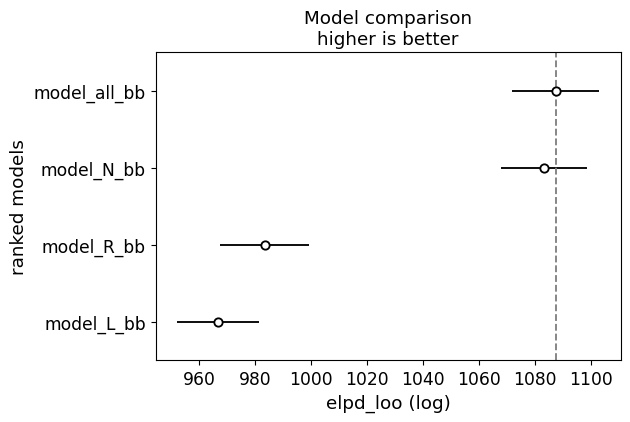

In [ ]:
compare = az.compare({"model_all_bb":idata_all_bb, "model_R_bb":idata_R_bb, "model_L_bb":idata_L_bb, "model_N_bb":idata_N_bb})
az.plot_compare(compare)

model_all_bb is clearly the strongest model. This is likely because it incorporates all the predictors, and they are all closely related to batting average. Although I am now realizing that adding base on balls does not help with predicting batting average, since it explicitly does not count towards a player's batting average.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 2100x1300 with 1 Axes>,
 array([<Axes: xlabel='OBP', ylabel='BA'>], dtype=object))

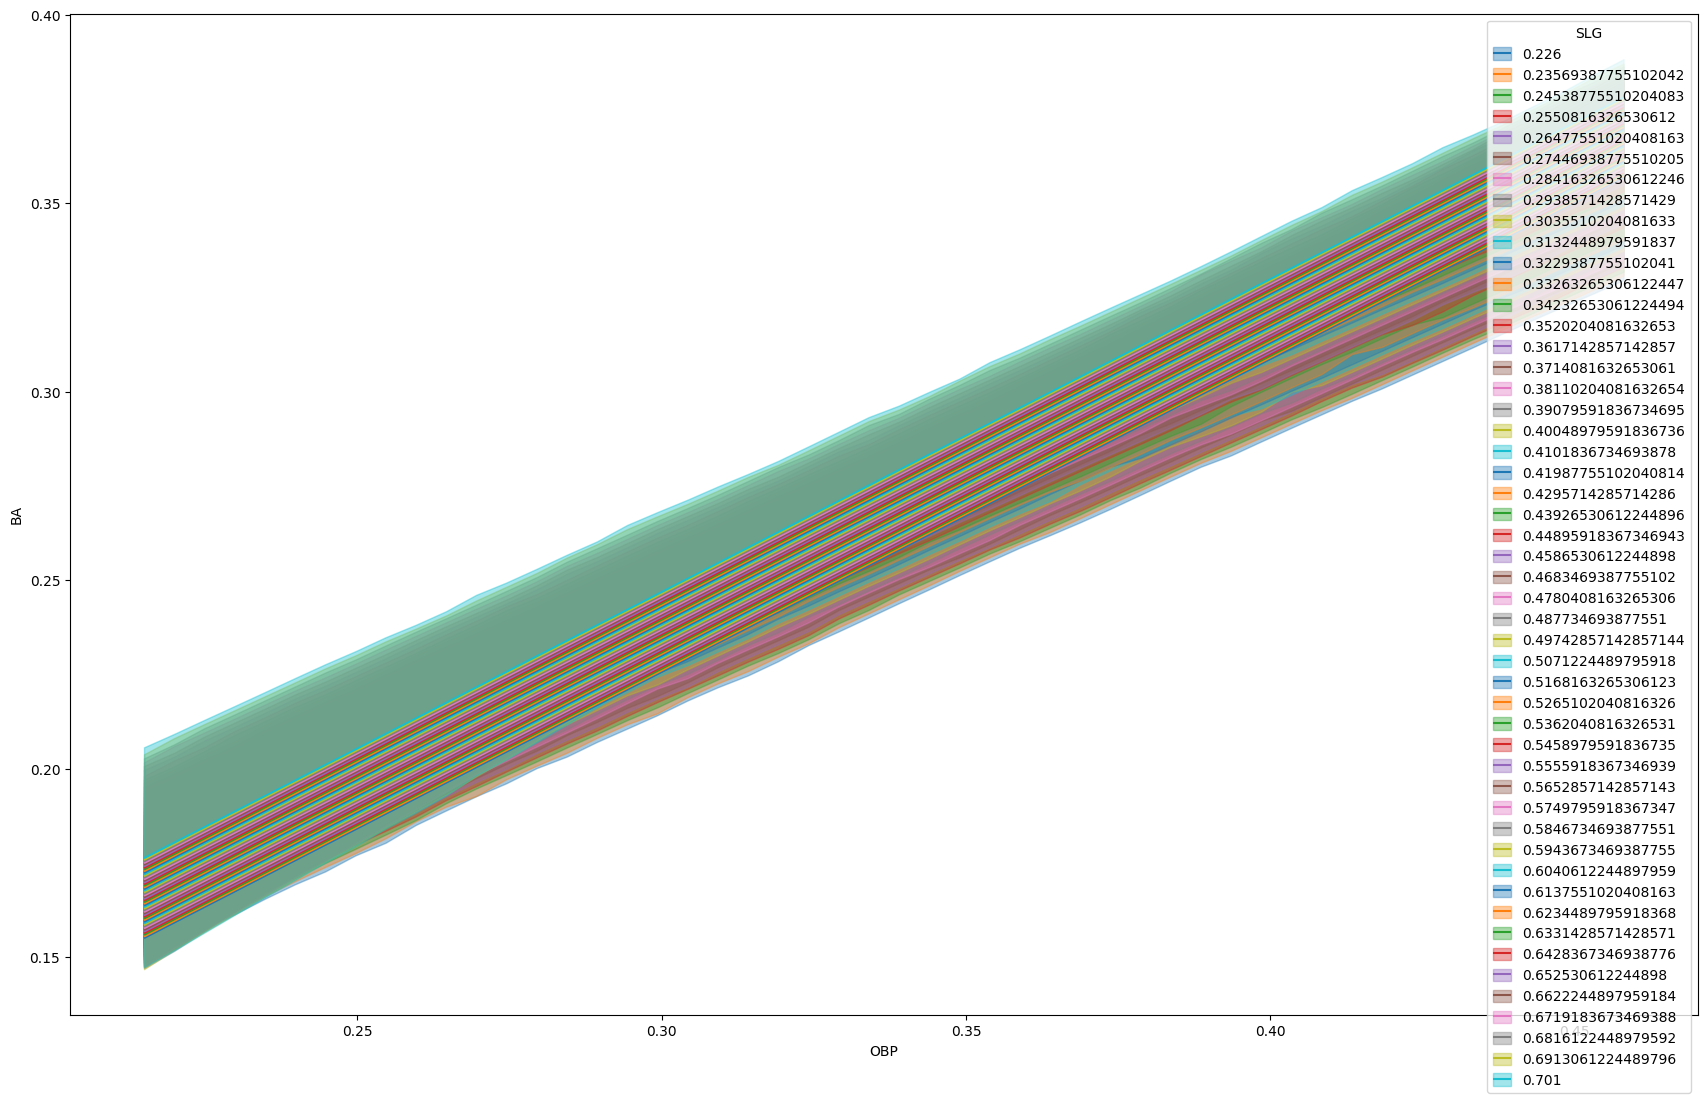

In [ ]:
bmb.interpret.plot_predictions(model_all_bb, idata_all_bb, ["OBP", "SLG"],
                               fig_kwargs={"figsize":(21,13)})

This shows pretty clearly that batting average increases with OBP, SLG, HR, and RBI. I'm excluding BB because that wasn;t actually needed as a predictor, but for the rest of the predictors, I think that this is a pretty obvious result, given how closely correlated they are with batting average.